In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, precision_score
import matplotlib.pyplot as plt

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42) 

In [4]:
class CustomAdaBoost:
    def __init__(self, n_estimators=50, max_depth=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        N, _ = X.shape
        weights = np.ones(N) / N 

        for _ in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=self.max_depth)
            stump.fit(X, y, sample_weight=weights)
            y_pred = stump.predict(X)

            misclassified = (y_pred != y)
            error = np.sum(weights * misclassified) / np.sum(weights)

            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            self.alphas.append(alpha)
            self.models.append(stump)

            weights *= np.exp(alpha * misclassified * 2)
            weights /= np.sum(weights) 

    def predict(self, X):
        final_prediction = sum(alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models))
        return np.sign(final_prediction)

In [5]:
num_trees_range = range(5, 156, 10) 
max_depth_range = range(1, 27, 5)  

best_accuracy = 0
best_params = {}

for num_trees in num_trees_range:
    for max_depth in max_depth_range:
        accuracies = []
        
        for seed in range(10):
            np.random.seed(seed)
            
            model = CustomAdaBoost(n_estimators=num_trees, max_depth=max_depth)
            model.fit(X_train, y_train)
            
            y_val_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)
            accuracies.append(accuracy)
        
        mean_accuracy = np.mean(accuracies)
        
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = {'n_estimators': num_trees, 'max_depth': max_depth}

print("Best Number of Trees:", best_params['n_estimators'])
print("Best Tree Depth:", best_params['max_depth'])
print("Best Validation Accuracy:", best_accuracy)

Best Number of Trees: 5
Best Tree Depth: 11
Best Validation Accuracy: 0.931764705882353


In [6]:
best_model = CustomAdaBoost(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision for each class:", precision)
print("Test Recall for each class:", recall)
print("Test F1-Score for each class:", f1)
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.9300699300699301
Test Precision for each class: [0.88888889 0.95505618]
Test Recall for each class: [0.92307692 0.93406593]
Test F1-Score for each class: [0.90566038 0.94444444]
Confusion Matrix:
 [[48  4]
 [ 6 85]]


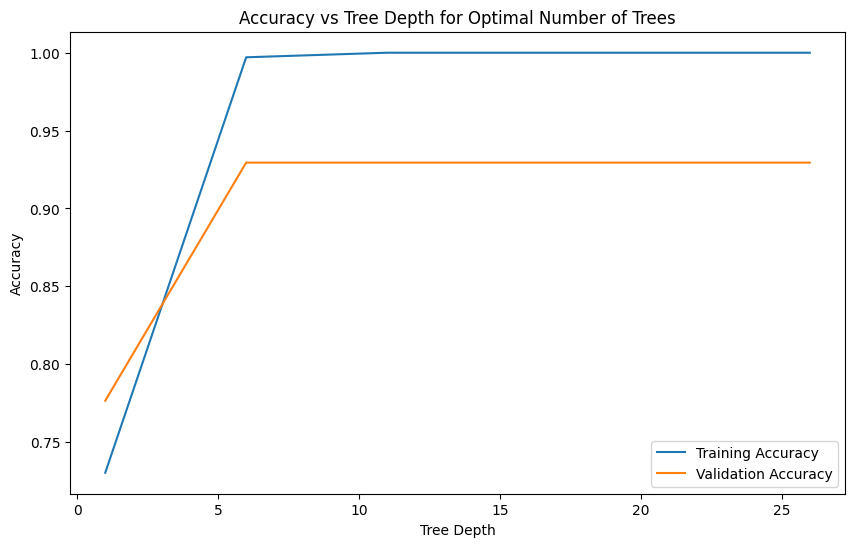

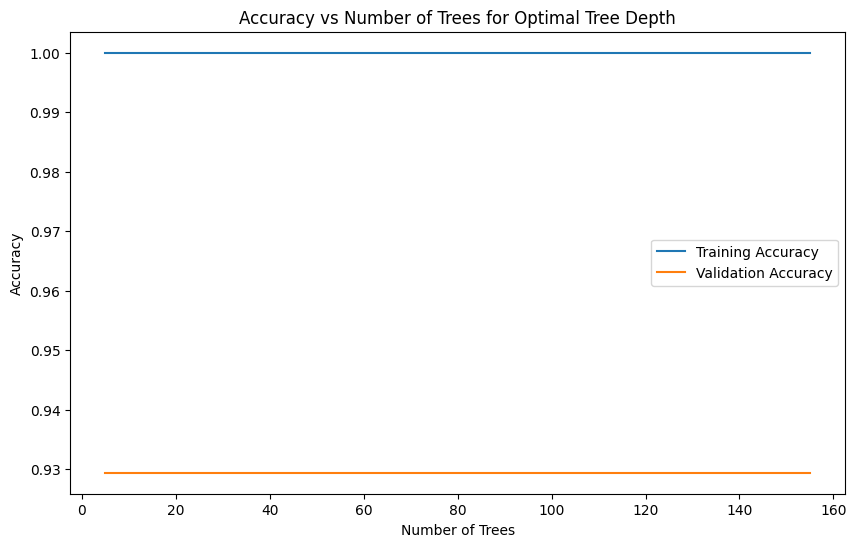

In [12]:
depth_accuracies = []

for depth in max_depth_range:
    model = CustomAdaBoost(n_estimators=best_params['n_estimators'], max_depth=depth)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    depth_accuracies.append((train_acc, val_acc))

depth_accuracies = np.array(depth_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, depth_accuracies[:, 0], label="Training Accuracy")
plt.plot(max_depth_range, depth_accuracies[:, 1], label="Validation Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth for Optimal Number of Trees")
plt.legend()
plt.show()

tree_accuracies = []

for num_trees in num_trees_range:
    model = CustomAdaBoost(n_estimators=num_trees, max_depth=best_params['max_depth'])
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    tree_accuracies.append((train_acc, val_acc))

tree_accuracies = np.array(tree_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(num_trees_range, tree_accuracies[:, 0], label="Training Accuracy")
plt.plot(num_trees_range, tree_accuracies[:, 1], label="Validation Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees for Optimal Tree Depth")
plt.legend()
plt.show()


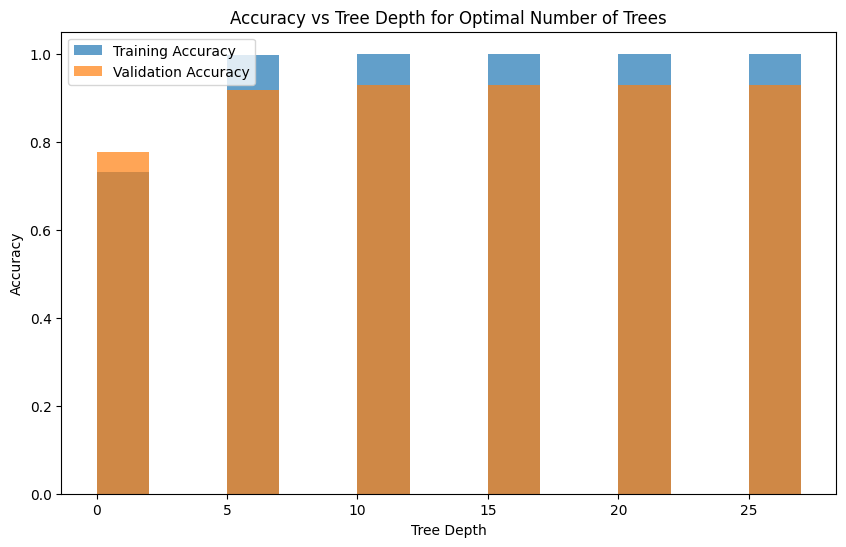

In [7]:
depth_accuracies = []

for depth in max_depth_range:
    model = CustomAdaBoost(n_estimators=best_params['n_estimators'], max_depth=depth)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    depth_accuracies.append((train_acc, val_acc))

depth_accuracies = np.array(depth_accuracies)

plt.figure(figsize=(10, 6))
plt.bar(max_depth_range, depth_accuracies[:, 0], width=2, label="Training Accuracy", alpha=0.7)
plt.bar(max_depth_range, depth_accuracies[:, 1], width=2, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tree Depth for Optimal Number of Trees")
plt.legend()
plt.show()

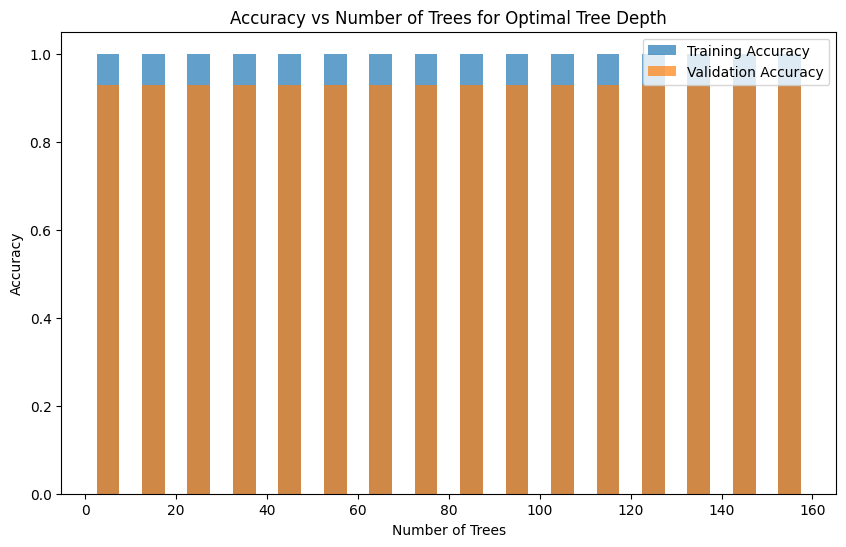

In [8]:
tree_accuracies = []

for num_trees in num_trees_range:
    model = CustomAdaBoost(n_estimators=num_trees, max_depth=best_params['max_depth'])
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    tree_accuracies.append((train_acc, val_acc))

tree_accuracies = np.array(tree_accuracies)

plt.figure(figsize=(10, 6))
plt.bar(num_trees_range, tree_accuracies[:, 0], width=5, label="Training Accuracy", alpha=0.7)
plt.bar(num_trees_range, tree_accuracies[:, 1], width=5, label="Validation Accuracy", alpha=0.7)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees for Optimal Tree Depth")
plt.legend()
plt.show()